# Stock-Duration-To-Come-Back-From-Crisis

In [73]:
import sys
sys.executable # Check in which virtual environment I am operating

'/Users/Armellini1/opt/anaconda3/envs/finenv/bin/python'

Generating a table with the worst crisis for a stock over a given period of time. And the time it took for the stock to come back to the initial price it had fallen from.

This will give an historical view of the kind of crises a company faced in its history, and the duration it took the company to recover form that crisis.


| Company   | Crisis     |  Low | from High | Change | got back by | after (years)
|-----------|----------- |------|-----------|--------|-------------|--------------
| Boeing    | 1973-03-10 | \$10 |  \$20     | -50%   |1976-09-10   |3.5

In [74]:
import numpy as np
import pandas as pd
import yfinance as yf # Module to retrieve data on financial instruments (similar to 'yahoo finance')
import matplotlib
from matplotlib import pyplot as plt # Import pyplot for plotting
from pandas.plotting import register_matplotlib_converters # to register Register Pandas Formatters and Converters with matplotlib.
from pandas.tseries.offsets import DateOffset
plt.style.use('seaborn') # using a specific matplotlib style
from dateutil.relativedelta import relativedelta

## Parameters

### `stock`

Captures the sock (company) to be studied. 

The variable should be set with the official "Ticker" of the company.

E.g: `stock = 'AAPL'` for Ticker AAPL (Ticker of the company Apple).

In [75]:
stock = 'BA' # stock under study. Boeing in this case.
stock_name = 'Boeing'

### `period`

Period of time under study. 

This is the period of time during which we want to find the crisis for the stock under study.

For example, it can be the last 5 years, the last 10 years or the maximum period for which we have data.

In [76]:
period = 'max' # valid period values: 1y,2y,5y,10y,ytd,max

### `time_window`

The time window is the moving time interval used to calculate the loss of the sotck.
At each point in time, the loss will be calculated compared to a reference point dated at the beginning of that time window.

This way, the loss calculated will be representative of the loss over that rolling time window.

E.g.: 
`time_window = '20'`
The change will be calculated over a rolling time window of 20 trading days.


In [77]:
time_window = 20 # in open trading days

### `large_loss`

A stock will be considered to have a crisis if the loss it suffers over the `time_window` is larger than `large_loss`.

In [78]:
large_loss = -0.30 # large loss (a percentage number: large_loss = -0.30 represents a loss of -30%)

## Implementation

### Get the stock historical price data for the period under study

Use the yfinance module to download the daily data for the period. And store the result in a Pandas DataFrame.

In [79]:
df = yf.download(tickers=stock, period= period, interval='1d') # Download the data
df.drop(columns=['Open','High','Low','Adj Close','Volume'],inplace=True) # Drop unnecessary columns
df.insert(0, 'Company', stock_name) # Insert a column "Company" with the stock name in it
df.head() # Display the first rows of the data

[*********************100%***********************]  1 of 1 completed


,Company,Close
Date,,
1962-01-02,Boeing,0.823045
1962-01-03,Boeing,0.839506
1962-01-04,Boeing,0.831276
1962-01-05,Boeing,0.814815
1962-01-08,Boeing,0.816872


### Calculate Change over the `time_window` rolling period

Create a column to store the reference price at the beginning of the time window.

In [80]:
df['Reference Price'] = df.Close.shift(time_window)
df

,Company,Close,Reference Price
Date,,,
1962-01-02,Boeing,0.823045,NaN
1962-01-03,Boeing,0.839506,NaN
1962-01-04,Boeing,0.831276,NaN
1962-01-05,Boeing,0.814815,NaN
1962-01-08,Boeing,0.816872,NaN
...,...,...,...
2020-03-23,Boeing,105.620003,317.899994
2020-03-24,Boeing,127.680000,304.140015
2020-03-25,Boeing,158.729996,305.589996


At the beginning of the data, we cannot get a reference point back the entire time window because we do not have the data before that point.

We will replace the missing values by the oldest possible price point available: the first historical price point available in the data.

In [81]:
df.fillna(value=df.iloc[0]['Close'],inplace=True)
df

,Company,Close,Reference Price
Date,,,
1962-01-02,Boeing,0.823045,0.823045
1962-01-03,Boeing,0.839506,0.823045
1962-01-04,Boeing,0.831276,0.823045
1962-01-05,Boeing,0.814815,0.823045
1962-01-08,Boeing,0.816872,0.823045
...,...,...,...
2020-03-23,Boeing,105.620003,317.899994
2020-03-24,Boeing,127.680000,304.140015
2020-03-25,Boeing,158.729996,305.589996


Calculate the change column: last "Close" compared to "Reference Price" (the reference price being the price of the stock at the start of the `time_window`.

In [82]:
df['Change'] = (df['Close']-df['Reference Price']) / df['Reference Price']
df

,Company,Close,Reference Price,Change
Date,,,,
1962-01-02,Boeing,0.823045,0.823045,0.000000
1962-01-03,Boeing,0.839506,0.823045,0.020000
1962-01-04,Boeing,0.831276,0.823045,0.010000
1962-01-05,Boeing,0.814815,0.823045,-0.010000
1962-01-08,Boeing,0.816872,0.823045,-0.007500
...,...,...,...,...
2020-03-23,Boeing,105.620003,317.899994,-0.667757
2020-03-24,Boeing,127.680000,304.140015,-0.580193
2020-03-25,Boeing,158.729996,305.589996,-0.480579


### Find the worst crisis

To find the worst crisis, we are going to search for local minimums in the "Change" column. 

And then find those "Change" local minimums that are inferior to the `large_loss` parameter.

E.g.: Worst crisis of Boeing over a month (loss larger than -30%).

In [83]:
# Create a column with the local minimums (change smaller than the one before and the one after)
df['Local Min'] = df.Change[ (df.Change.shift(1)>df.Change) & (df.Change.shift(-1)>df.Change) ] 
df

,Company,Close,Reference Price,Change,Local Min
Date,,,,,
1962-01-02,Boeing,0.823045,0.823045,0.000000,NaN
1962-01-03,Boeing,0.839506,0.823045,0.020000,NaN
1962-01-04,Boeing,0.831276,0.823045,0.010000,NaN
1962-01-05,Boeing,0.814815,0.823045,-0.010000,-0.01
1962-01-08,Boeing,0.816872,0.823045,-0.007500,NaN
...,...,...,...,...,...
2020-03-23,Boeing,105.620003,317.899994,-0.667757,NaN
2020-03-24,Boeing,127.680000,304.140015,-0.580193,NaN
2020-03-25,Boeing,158.729996,305.589996,-0.480579,NaN


Address the fact that the very last price could be a local minimum as well.

If the very last price is smaller than the day before, then consider it as a local minimum as well.

In [84]:
if df.loc[df.index[-1],'Change'] < df.loc[df.index[-2],'Change']: # if the last change is smaller tham the day before  
    df.loc[df.index[-1],'Local Min'] = df.loc[df.index[-1],'Change'] # consider the last change as a local minimum
    
df

,Company,Close,Reference Price,Change,Local Min
Date,,,,,
1962-01-02,Boeing,0.823045,0.823045,0.000000,NaN
1962-01-03,Boeing,0.839506,0.823045,0.020000,NaN
1962-01-04,Boeing,0.831276,0.823045,0.010000,NaN
1962-01-05,Boeing,0.814815,0.823045,-0.010000,-0.010000
1962-01-08,Boeing,0.816872,0.823045,-0.007500,NaN
...,...,...,...,...,...
2020-03-23,Boeing,105.620003,317.899994,-0.667757,NaN
2020-03-24,Boeing,127.680000,304.140015,-0.580193,NaN
2020-03-25,Boeing,158.729996,305.589996,-0.480579,NaN


Find out the worst crisis by selecting  the rows for which the Change has a Local Minimum inferior to the `large_loss` parameter defined at the top of the Notebook.

`df1`will be a smaller copy of the larger `df`. `df1` being will be used to ultimately represent the final output of that entire Notebook.

In [85]:
df1 = df[ df['Local Min'] < large_loss ].copy()
df1

,Company,Close,Reference Price,Change,Local Min
Date,,,,,
1970-02-05,Boeing,0.699588,1.020576,-0.314516,-0.314516
1973-12-03,Boeing,0.465021,0.666667,-0.302469,-0.302469
1973-12-05,Boeing,0.448560,0.658436,-0.318750,-0.318750
2001-09-18,Boeing,33.139999,55.889999,-0.407050,-0.407050
2001-09-20,Boeing,29.760000,55.130001,-0.460185,-0.460185
2001-09-26,Boeing,34.290001,52.299999,-0.344359,-0.344359
2001-10-01,Boeing,32.400002,53.060001,-0.389371,-0.389371
2008-10-10,Boeing,41.799999,63.299999,-0.339652,-0.339652
2009-03-02,Boeing,29.510000,42.310001,-0.302529,-0.302529


It happens that we have several local minimums in the span of a `time_window`.

In order to avoid redundancy and keep only the worst loss point for each crisis, we will keep only the largest loss endured during the span of a given `time_window`.

The following function will use a `time_cursor` that will go iteratively at the start of each `time_window`, get the local minimums for that `time_window`, and keep only the worst date as being representative of the crisis during that `time_window`.

In [86]:
def get_single_crisis_dates_per_time_window(df):
    '''
    DOCSTRING:
    INPUT: a DataFrame with local minimus of Change, with possibly several local minimums per time_window.
    OUTPUT: List of dates corresponding to the worst data points (worst loss) within each time_window.
    The output is the final list of crisis dates for that Stock over the period under study.
    '''
    crisis_dates = [] # initiate a list that will contain the crisis dates
    time_cursor = df.index[0] # initiate a time cursor that will move at the start of each time_window to consider
    # print(f'time_cursor initiated at: {time_cursor}')
    time_window_df = df.loc[time_cursor:time_cursor+DateOffset(months=1)] # data within the time_window being pointed out by the cursor

    # Loop running as long as the cursor can be moved to a next time_window (i.e as long as there are dates moving forward)
    while True:
        
        # print('\n')
        # print( time_window_df )
        # get the date of the worst crisis during the time_window and append to the list of crisis dates
        crisis_dates.append( time_window_df['Change'].idxmin() ) 
        # print(f'\nThe crisis dates so far are: {crisis_dates}')

        # Try to get the next row after that time_window, and place the time_cursor there
        try:
            next_row = df[ time_window_df.index[-1] : ].iloc[1] # Try to get the next row after that time_window
            time_cursor = next_row.name # place the time_cursor at the date corresponding to that next row
            # print(f'Moving the time_cursor to the start of the next time window to consider: {time_cursor}')
            time_window_df = df.loc[time_cursor:time_cursor+DateOffset(months=1)] # update the data being pointed out by the time_cursor

        # If no next row, we are at the end of the data and we can break the loop there
        except:
            # print(f'There is not next date to which to move the the time cursor that is currently at {time_cursor}\nBREAK OUT OF THE LOOP')
            break
            
    return crisis_dates

In [87]:
stock_crisis_dates = get_single_crisis_dates_per_time_window(df1)

### We found the worst crisis dates:

In [88]:
stock_crisis_dates

[Timestamp('1970-02-05 00:00:00'),
 Timestamp('1973-12-05 00:00:00'),
 Timestamp('2001-09-20 00:00:00'),
 Timestamp('2008-10-10 00:00:00'),
 Timestamp('2009-03-02 00:00:00'),
 Timestamp('2020-03-20 00:00:00')]

The data corresponding to those dates is:

In [89]:
df1 = df1.loc[stock_crisis_dates] # limit df1 (target output of the Notebook) to worst crisis dates only
df1

,Company,Close,Reference Price,Change,Local Min
Date,,,,,
1970-02-05,Boeing,0.699588,1.020576,-0.314516,-0.314516
1973-12-05,Boeing,0.448560,0.658436,-0.318750,-0.318750
2001-09-20,Boeing,29.760000,55.130001,-0.460185,-0.460185
2008-10-10,Boeing,41.799999,63.299999,-0.339652,-0.339652
2009-03-02,Boeing,29.510000,42.310001,-0.302529,-0.302529
2020-03-20,Boeing,95.010002,330.380005,-0.712422,-0.712422


### Find the date by which the stock comes back to its initial price

For a given crisis, we are going to retrieve the date by which the stock came back to the reference price from which it has fallen.

In [90]:
for crisis_date in df1.index: # Iterate through crisis dates
    # Try to get the first day after the crisis  where the stock closed higher than the Reference Price. 
    # If it exists (thus the Try)
    try: 
        df1.loc[crisis_date,'got back by'] = df.loc[ ( df.index > crisis_date ) & 
                                                    ( df.Close > df.loc[crisis_date,'Reference Price']) ].iloc[0].name.date()
    except:
        print(f'Could not find a date by which the stock got back to its reference price for crisis dated:Ù{crisis_date}')
df1

Could not find a date by which the stock got back to its reference price for crisis dated:Ù2020-03-20 00:00:00


,Company,Close,Reference Price,Change,Local Min,got back by
Date,,,,,,
1970-02-05,Boeing,0.699588,1.020576,-0.314516,-0.314516,1975-06-03
1973-12-05,Boeing,0.448560,0.658436,-0.318750,-0.318750,1974-08-22
2001-09-20,Boeing,29.760000,55.130001,-0.460185,-0.460185,2004-09-17
2008-10-10,Boeing,41.799999,63.299999,-0.339652,-0.339652,2010-02-19
2009-03-02,Boeing,29.510000,42.310001,-0.302529,-0.302529,2009-05-05
2020-03-20,Boeing,95.010002,330.380005,-0.712422,-0.712422,NaN


And indicate the duration it took for the stock to come back to its reference price (to come back from the crisis)

In [91]:
# transform the index in a series of dates and calculate duration for stock to come back from crisis
df1['Duration (years)'] = df1['got back by'] - pd.to_datetime(df1.index.to_series()).dt.date  
# Get the number of days of the duraction object and divide by 365 to get years
df1['Duration (years)'] = df1['Duration (years)'].apply(lambda x: x.days / 365)
df1

,Company,Close,Reference Price,Change,Local Min,got back by,Duration (years)
Date,,,,,,,
1970-02-05,Boeing,0.699588,1.020576,-0.314516,-0.314516,1975-06-03,5.326027
1973-12-05,Boeing,0.448560,0.658436,-0.318750,-0.318750,1974-08-22,0.712329
2001-09-20,Boeing,29.760000,55.130001,-0.460185,-0.460185,2004-09-17,2.994521
2008-10-10,Boeing,41.799999,63.299999,-0.339652,-0.339652,2010-02-19,1.361644
2009-03-02,Boeing,29.510000,42.310001,-0.302529,-0.302529,2009-05-05,0.175342
2020-03-20,Boeing,95.010002,330.380005,-0.712422,-0.712422,NaN,NaN


Develop the duration into the exact number of years, months and days:

In [92]:
for i in range(len(df1)-1):
    my_relative_delta = relativedelta( df1.loc[df1.index[i],'got back by'] , pd.to_datetime(df1.index.to_series()).dt.date[i] )
    df1.loc[df1.index[i],'years'] = my_relative_delta.years
    df1.loc[df1.index[i],'months'] = my_relative_delta.months
    df1.loc[df1.index[i],'days'] = my_relative_delta.days
df1


,Company,Close,Reference Price,Change,Local Min,got back by,Duration (years),years,months,days
Date,,,,,,,,,,
1970-02-05,Boeing,0.699588,1.020576,-0.314516,-0.314516,1975-06-03,5.326027,5.0,3.0,29.0
1973-12-05,Boeing,0.448560,0.658436,-0.318750,-0.318750,1974-08-22,0.712329,0.0,8.0,17.0
2001-09-20,Boeing,29.760000,55.130001,-0.460185,-0.460185,2004-09-17,2.994521,2.0,11.0,28.0
2008-10-10,Boeing,41.799999,63.299999,-0.339652,-0.339652,2010-02-19,1.361644,1.0,4.0,9.0
2009-03-02,Boeing,29.510000,42.310001,-0.302529,-0.302529,2009-05-05,0.175342,0.0,2.0,3.0
2020-03-20,Boeing,95.010002,330.380005,-0.712422,-0.712422,NaN,NaN,NaN,NaN,NaN


### Rename the columns to make it more readable as a final output

In [93]:
# Rename columns to make it more readable
df1.rename(columns={'Close': 'Low', 'Reference Price':'from High', 'Duration (years)':'after (years)'}, inplace=True)
# Drop unnecessary columns
df1.drop(columns=['Local Min','Company'],inplace=True)
# Rename the index to "Crisis"
df1.index.rename('Crisis',inplace=True)
df1

,Low,from High,Change,got back by,after (years),years,months,days
Crisis,,,,,,,,
1970-02-05,0.699588,1.020576,-0.314516,1975-06-03,5.326027,5.0,3.0,29.0
1973-12-05,0.448560,0.658436,-0.318750,1974-08-22,0.712329,0.0,8.0,17.0
2001-09-20,29.760000,55.130001,-0.460185,2004-09-17,2.994521,2.0,11.0,28.0
2008-10-10,41.799999,63.299999,-0.339652,2010-02-19,1.361644,1.0,4.0,9.0
2009-03-02,29.510000,42.310001,-0.302529,2009-05-05,0.175342,0.0,2.0,3.0
2020-03-20,95.010002,330.380005,-0.712422,NaN,NaN,NaN,NaN,NaN


# RESULT

In [94]:
df2 = df1.copy()
df2['Change'] = df2['Change']*100 # Make the percentage readable as %

In [95]:
# Formatting the numbers
df2.index = df1.index.strftime("%Y-%m-%d") # Replace the index by formatted strings Y-d-m
df2.style.format({'Low':'${:.2f}','from High':'${:.2f}','Change':'{:.2f}%','got back by':'{}','after (years)':'{:.2f}',
                  'years':'{:.0f}','months':'{:.0f}','days':'{:.0f}'},na_rep="-")\
        .bar(subset=['Change'],color='#E98888',align='mid')\
        .bar(subset=['after (years)'],color='#88ABE9',align='mid')\
        .set_caption(f"Company: {stock_name}")



,Low,from High,Change,got back by,after (years),years,months,days
Crisis,,,,,,,,
1970-02-05,$0.70,$1.02,-31.45%,1975-06-03,5.33,5,3,29
1973-12-05,$0.45,$0.66,-31.88%,1974-08-22,0.71,0,8,17
2001-09-20,$29.76,$55.13,-46.02%,2004-09-17,2.99,2,11,28
2008-10-10,$41.80,$63.30,-33.97%,2010-02-19,1.36,1,4,9
2009-03-02,$29.51,$42.31,-30.25%,2009-05-05,0.18,0,2,3
2020-03-20,$95.01,$330.38,-71.24%,-,-,-,-,-


In [96]:
#df.to_csv('BA.csv')

## ANNEX (Plot)

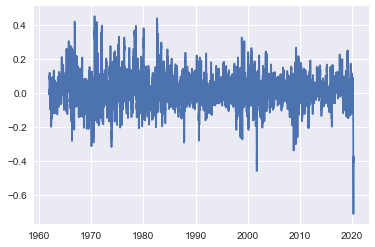

In [97]:
# Will allow us to embed images in the notebook
%matplotlib inline

register_matplotlib_converters()

# Create a figure containing a single axes
fig, ax = plt.subplots()

# Draw on the axes
ax.plot(df.index.values,df['Change'])

plt.show()